In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df = pd.read_csv('/content/drive/My Drive/NLP Final/dataset.csv')
df.dropna(inplace=True)

In [0]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df['text'])

In [0]:
df['text'] = tokenizer.texts_to_sequences(df['text'])

In [0]:
X_lens = [len(x) for x in df['text'].values]

In [0]:
X_lens = np.array(X_lens)

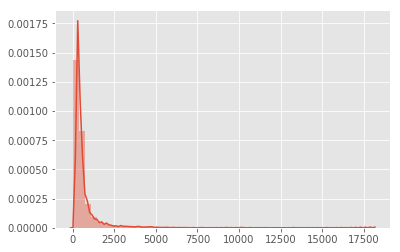

In [0]:
import seaborn as sns
sns.distplot(X_lens)

In [0]:
np.mean(X_lens)

622.0563602325352

In [0]:
np.std(X_lens)

1182.0848019657983

In [0]:
2 * 1182 + 622

2986

In [0]:
np.unique((X_lens > 2986), return_counts=True)

(array([False,  True]), array([19689,   609]))

In [0]:
len(X_lens)

20298

In [0]:
19689 / 20298

0.9699970440437482

In [0]:
len(tokenizer.index_word)

161431

In [0]:
#one_hot_source = pd.get_dummies(df[['source']])

In [0]:
df.drop('source', axis=1, inplace=True)
#df = pd.concat([df, one_hot_source], axis=1)

In [0]:
title_tokenizer = tf.keras.preprocessing.text.Tokenizer()
title_tokenizer.fit_on_texts(df['title'])
df['title'] = title_tokenizer.texts_to_sequences(df['title'])

In [0]:
title_lens = [len(x) for x in df['title'].values]

In [0]:
title_lens = np.array(title_lens)

In [0]:
np.mean(title_lens)

11.158833382599271

In [0]:
np.std(title_lens)

3.969126103383346

In [0]:
4 * 2 + 11

19

In [0]:
np.unique((title_lens > 19), return_counts=True)

(array([False,  True]), array([19898,   400]))

In [0]:
len(title_lens)

20298

In [0]:
19898/20298

0.9802936249876835

In [0]:
len(title_tokenizer.index_word)

22405

In [0]:
df.drop('id', axis=1, inplace=True)

In [0]:
labels = df.pop('label')

In [0]:
labels.replace({'fake': 1, 'real': 0}, inplace=True)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df, labels)

In [0]:
X_train_title = X_train.pop('title')
X_test_title = X_test.pop('title')

X_train_text = X_train.pop('text')
X_test_text = X_test.pop('text')

In [0]:
X_train.iloc[0].shape

(21,)

In [0]:
X_train_title = tf.keras.preprocessing.sequence.pad_sequences(X_train_title, 
                                                              maxlen=19, 
                                                              padding='post', 
                                                              truncating='post')
X_test_title = tf.keras.preprocessing.sequence.pad_sequences(X_test_title, 
                                                              maxlen=19, 
                                                              padding='post', 
                                                              truncating='post')

In [0]:
X_train_text = tf.keras.preprocessing.sequence.pad_sequences(X_train_text, 
                                                             maxlen=2986, 
                                                             padding='post', 
                                                             truncating='post')
X_test_text = tf.keras.preprocessing.sequence.pad_sequences(X_test_text, 
                                                             maxlen=2986, 
                                                             padding='post', 
                                                             truncating='post')

In [0]:
text_input = tf.keras.layers.Input(shape=(2986,), name='article_body_input')
text_embed = tf.keras.layers.Embedding(161431 + 1, 50, input_length=2986, name='article_body_embedding')(text_input)
text_conv = tf.keras.layers.Conv1D(256, 10, name='article_body_conv')(text_embed)
text_pool = tf.keras.layers.GlobalMaxPool1D(name='article_body_pooling')(text_conv)

title_input = tf.keras.layers.Input(shape=(19,), name = 'article_title_input')
title_embed = tf.keras.layers.Embedding(22405 + 1, 50, input_length=19, name='article_title_embedding')(title_input)
title_conv = tf.keras.layers.Conv1D(256, 3, name='article_title_conv')(title_embed)
title_pool = tf.keras.layers.GlobalMaxPooling1D(name='article_title_pooling')(title_conv)

vector_input = tf.keras.layers.Input(shape=(21,), name='twitter_input')
concat = tf.keras.layers.concatenate([text_pool, title_pool, vector_input])
dense_100 = tf.keras.layers.Dense(100, activation='relu')(concat)
dense_50 = tf.keras.layers.Dense(50, activation='relu')(dense_100)
out_layer = tf.keras.layers.Dense(1, activation='sigmoid')(dense_50)

model = tf.keras.models.Model(inputs=[text_input, title_input, vector_input], outputs=out_layer)
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
article_body_input (InputLayer) [(None, 2986)]       0                                            
__________________________________________________________________________________________________
article_title_input (InputLayer [(None, 19)]         0                                            
__________________________________________________________________________________________________
article_body_embedding (Embeddi (None, 2986, 50)     8071600     article_body_input[0][0]         
__________________________________________________________________________________________________
article_title_embedding (Embedd (None, 19, 50)       1120300     article_title_input[0][0]        
____________________________________________________________________________________________

In [0]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', 
                                            patience=5, mode='max', 
                                            restore_best_weights=True)
history = model.fit([X_train_text, X_train_title, X_train], 
                    y_train, 
                    epochs=100, 
                    batch_size=128, 
                    validation_data=(
                        [X_test_text, X_test_title, X_test], 
                        y_test
                    ), 
                    callbacks=[callback])

Train on 15223 samples, validate on 5075 samples
Epoch 1/100
15223/15223 [==============================] - 13s 870us/sample - loss: 8464.7137 - acc: 0.7352 - val_loss: 5965.9353 - val_acc: 0.7963
Epoch 2/100
15223/15223 [==============================] - 13s 865us/sample - loss: 13273.9663 - acc: 0.7710 - val_loss: 6457.2780 - val_acc: 0.7708
Epoch 3/100
15223/15223 [==============================] - 13s 866us/sample - loss: 12064.4757 - acc: 0.7674 - val_loss: 5398.1201 - val_acc: 0.8091
Epoch 4/100
15223/15223 [==============================] - 13s 857us/sample - loss: 6799.7959 - acc: 0.8003 - val_loss: 3624.9357 - val_acc: 0.8329
Epoch 5/100
15223/15223 [==============================] - 13s 849us/sample - loss: 8496.1576 - acc: 0.7981 - val_loss: 9215.6288 - val_acc: 0.8219
Epoch 6/100
15223/15223 [==============================] - 13s 844us/sample - loss: 4368.5980 - acc: 0.8245 - val_loss: 4210.2363 - val_acc: 0.8522
Epoch 7/100
15223/15223 [==============================] - 13

In [0]:
# ref https://realpython.com/python-keras-text-classification/
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

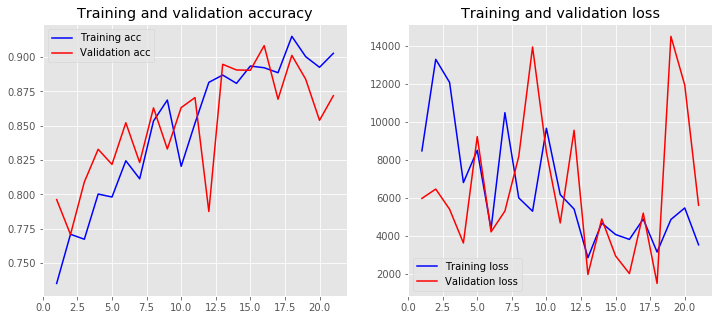

In [0]:
plot_history(history)

In [0]:
preds = model.predict([X_test_text, X_test_title, X_test])

In [0]:
model.evaluate([X_test_text, X_test_title, X_test], y_test)

5075/5075 [==============================] - 2s 304us/sample - loss: 2018.9578 - acc: 0.9084


[2018.9578359759853, 0.90837437]

In [0]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [0]:
precision_score(y_test.values, preds.reshape(-1).astype('int64'))

0.8259005145797599

In [0]:
recall_score(y_test.values, preds.reshape(-1).astype('int64'))

0.7874080130825838

In [0]:
f1_score(y_test.values, preds.reshape(-1).astype('int64'))

0.8061950606948515

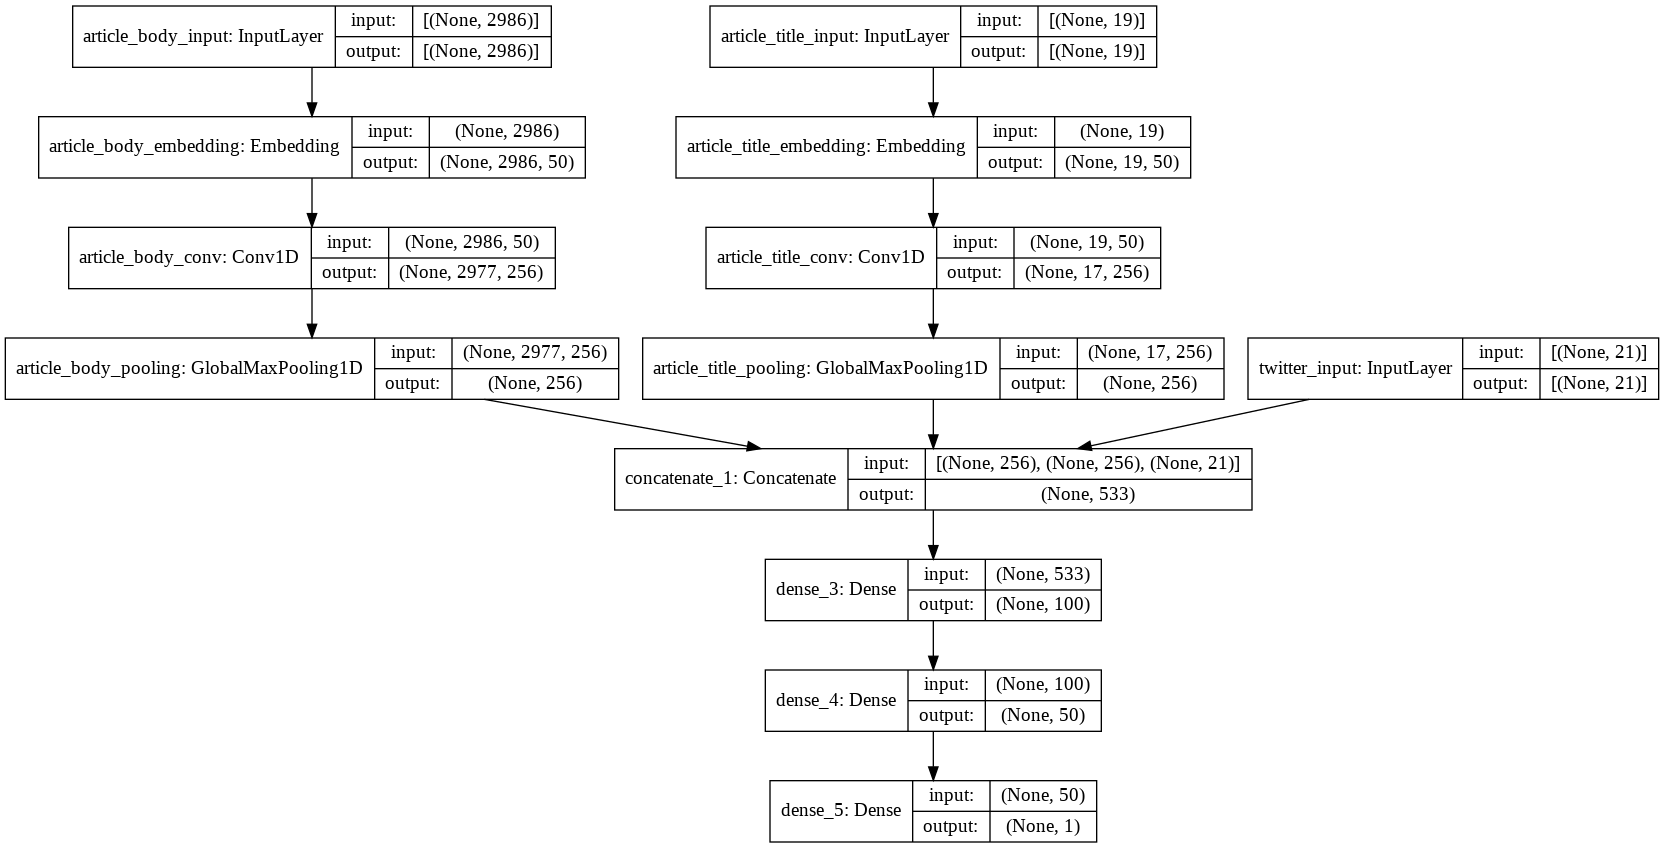

In [0]:
tf.keras.utils.plot_model(model, 'model_graph.png', show_shapes=True)

In [0]:
!cp model_graph.png /content/drive/My\ Drive/NLP\ Final/model_graph.png